# **HEART FAILURE PREDICTION**

Lucija Dumančić

## **Uvod**

Stupci:

1.   **Age**: godine pacijenta
2.   **Sex**: spol pacijenta [M: muško, F: žensko]
3.   **ChestPainType**: vrsta boli u prsima[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4.    **RestingBP**: krvni tlak [mmHg]
5.    **Cholesterol**: kolesterol u serumu [mg/dl]
6.    **FastingBS**: šećer u krvi natašte [1: ako je FastingBS > 120 mg/dl, 0: inače]
7.    **RestingECG**: rezultati EKG-a [Normal: Normalni, ST: abnormalnost ST-T vala, LVH: vjerojatno ili definitivnu hipertrofiju lijeve klijetke prema Estesovim kriterijima]
8.    **MaxHR**: postignut maksimalni broj otkucaja srca [numerička vrijednost između 50 i 202]
9.    **ExerciseAngina**: angina izazvana vježbanjem [Y: da, N: ne]
10.   **Oldpeak**: ST [numerička vrijednost mjerenja u depresiji]
11.   **ST_Slope**: nagib ST segmenta [Up: uzlazno, Flat: ravno, Down: nizbrdo ]
12.   **HeartDisease**: izlazna klasa [1: srčana bolest, 0: normalno]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/SU/projekt

/content/drive/MyDrive/SU/projekt


In [3]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.1 MB/s eta 0:00:00


In [4]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=79d98521774c6398ac650ae0859b3b6989343cd37559b7618e3de07e813d78c2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Dense, Input, Conv1D, MaxPooling1D, Flatten

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

import shap
shap.initjs()

## **Priprema podataka**

In [6]:
data = pd.read_csv("heart.csv")
data.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [ ]:
data.shape

(918, 12)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Data type:**

In [ ]:
num_data = data.select_dtypes(exclude = object)
cat_data = data.select_dtypes(include = object)

print(f"Numeric variables: {num_data.columns.values}")
print(f"Categorical variables: {cat_data.columns.values}")

Numeric variables: ['Age' 'RestingBP' 'Cholesterol' 'FastingBS' 'MaxHR' 'Oldpeak'
 'HeartDisease']
Categorical variables: ['Sex' 'ChestPainType' 'RestingECG' 'ExerciseAngina' 'ST_Slope']


**Missing values:**

In [ ]:
na_values = data.isnull().sum()
percentage = data.isnull().sum()/data.shape[0]*100

value = {
    "na_values": na_values,
    "percentage": percentage
}
frame = pd.DataFrame(value)
frame

na_values  percentage
Age                     0         0.0
Sex                     0         0.0
ChestPainType           0         0.0
RestingBP               0         0.0
Cholesterol             0         0.0
FastingBS               0         0.0
RestingECG              0         0.0
MaxHR                   0         0.0
ExerciseAngina          0         0.0
Oldpeak                 0         0.0
ST_Slope                0         0.0
HeartDisease            0         0.0

**Duplicates:**

In [ ]:
len(data[data.duplicated()])

0

## **Analiza**

In [ ]:
data.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

#### Age

In [7]:
age_counts = data['Age'].value_counts().sort_index()

print(age_counts)
print(len(age_counts))

Age
28     1
29     3
30     1
31     2
32     5
33     2
34     7
35    11
36     6
37    11
38    16
39    15
40    13
41    24
42    18
43    24
44    19
45    18
46    24
47    19
48    31
49    21
50    25
51    35
52    36
53    33
54    51
55    41
56    38
57    38
58    42
59    35
60    32
61    31
62    35
63    30
64    22
65    21
66    13
67    15
68    10
69    13
70     7
71     5
72     4
73     1
74     7
75     3
76     2
77     2
Name: count, dtype: int64
50


In [8]:
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['0 - 20', '20 - 40', '40 - 60', '60 - 80', '80 - 100']

data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

In [9]:
data["Age_Group"].value_counts()

Age_Group
40 - 60     585
60 - 80     253
20 - 40      80
0 - 20        0
80 - 100      0
Name: count, dtype: int64

In [10]:
selected_columns = data[['Age', 'Age_Group']]
print(selected_columns[:100])

    Age Age_Group
0    40   40 - 60
1    49   40 - 60
2    37   20 - 40
3    48   40 - 60
4    54   40 - 60
..  ...       ...
95   58   40 - 60
96   43   40 - 60
97   39   20 - 40
98   56   40 - 60
99   41   40 - 60

[100 rows x 2 columns]


In [11]:
data = data.drop("Age", axis = 1)

In [12]:
data['Age_Group'] = data['Age_Group'].astype('object')

In [13]:
data.head()

Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   M           ATA        140          289          0     Normal    172   
1   F           NAP        160          180          0     Normal    156   
2   M           ATA        130          283          0         ST     98   
3   F           ASY        138          214          0     Normal    108   
4   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease Age_Group  
0              N      0.0       Up             0   40 - 60  
1              N      1.0     Flat             1   40 - 60  
2              N      0.0       Up             0   20 - 40  
3              Y      1.5     Flat             1   40 - 60  
4              N      0.0       Up             0   40 - 60

## **Izvlačenje obilježja**

**Skaliranje numeričkih varijabli:**

In [14]:
numerical = data.select_dtypes(exclude=object).columns

In [15]:
for col in numerical:
    data[col] = MinMaxScaler().fit_transform(data[[col]])

**Outliers:**

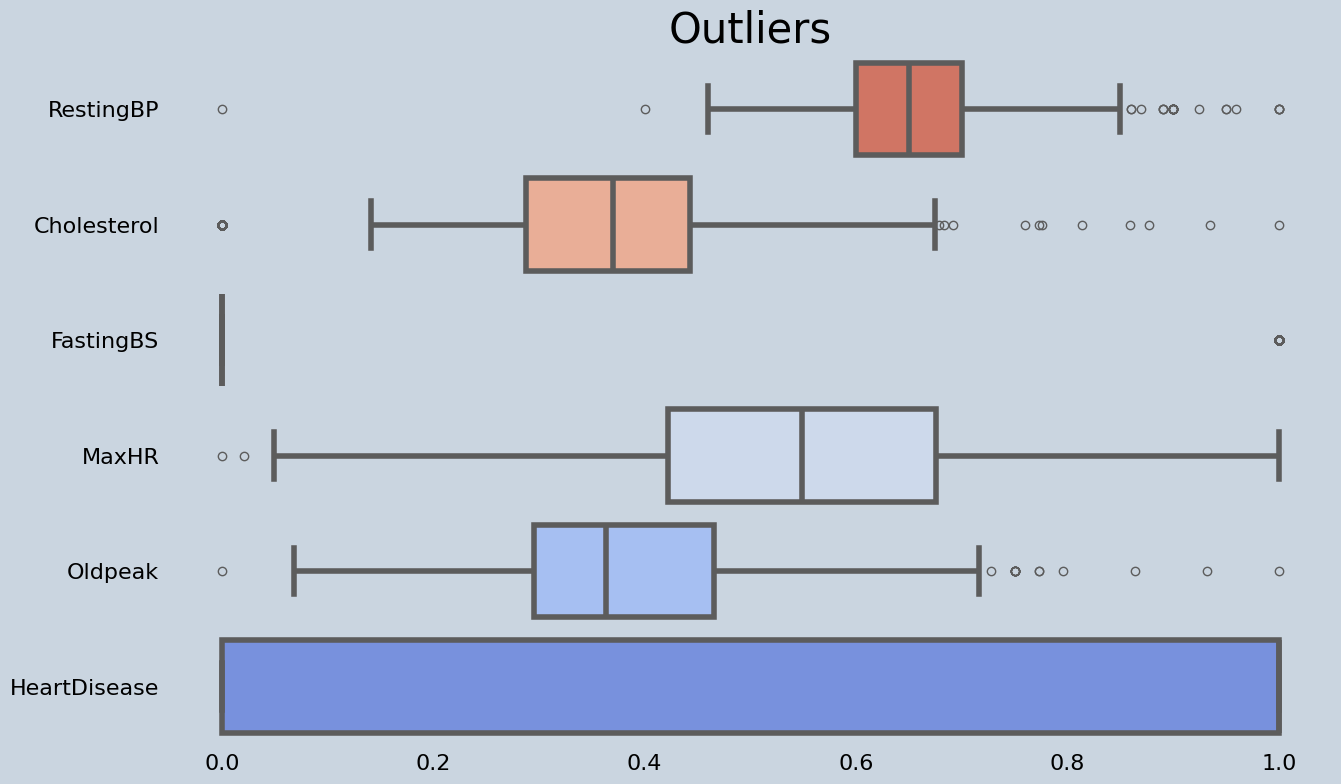

In [16]:
fig, ax = plt.subplots(figsize =(15,9))
ax.patch.set_facecolor('#CAD5E0')
fig.patch.set_facecolor('#CAD5E0')

sns.boxplot(data = data, ax=ax, palette='coolwarm_r', orient="h", linewidth=4);

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

ax.grid(False)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);


ax.set_title('Outliers', fontsize=30);

Možemo primjetiti da stupac 'RestingBP', koji predstavlja krvni tlak pacijenta, ima jednu vrijednost koja iznosi 0, što je nemoguće. Stoga ćemo taj outlier ukloniti.

In [17]:
data = data.drop(data[(data['RestingBP'] == 0)].index)

***RestingBP outliers:***

In [18]:
q1 = data['RestingBP'].quantile(0.25)
q3 = data['RestingBP'].quantile(0.75)
iqr = q3 - q1
lower_tail = q1 - 1.5 * iqr
upper_tail = q3 + 1.5 * iqr

u = data[(data['RestingBP'] >= upper_tail) | (data['RestingBP'] <= lower_tail)]
u = pd.DataFrame(u)
print(f"Outliers on RestingBP:\r\n{u.value_counts(u['HeartDisease'])}")

Outliers on RestingBP:
HeartDisease
1.0    17
0.0    10
Name: count, dtype: int64


Outlieri nisu ekstremno neuravnoteženi za 'HeartDisease', stoga ćemo koristiti median kako bi uklonili outliere iz varijable 'RestingBP'.

In [19]:
RestingBP_med = np.median(data['RestingBP'])

for i in data['RestingBP']:
  if i > upper_tail or i < lower_tail:
    data['RestingBP'] = data['RestingBP'].replace(i, RestingBP_med)

***Cholesterol outliers:***

In [20]:
q1 = data['Cholesterol'].quantile(0.25)
q3 = data['Cholesterol'].quantile(0.75)
iqr = q3 - q1
lower_tail = q1 - 1.5 * iqr
upper_tail = q3 + 1.5 * iqr

u = data[(data['Cholesterol'] >= upper_tail) | (data['Cholesterol'] <= lower_tail)]
u = pd.DataFrame(u)
print(f"Outliers on Cholesterol:\r\n{u.value_counts(u['HeartDisease'])}")

Outliers on Cholesterol:
HeartDisease
1.0    158
0.0     25
Name: count, dtype: int64


In [21]:
z = data[data['Cholesterol'] == 0]
z = pd.DataFrame(z)
z.value_counts(data['HeartDisease'])

HeartDisease
1.0    151
0.0     20
Name: count, dtype: int64

Gotovo svi pacijenti s 'Cholesterol' jednakim 0 imaju srčanu bolest. Iz tog razloga, nećemo uklanjati outliere jednake 0 u ovoj značajki. <br> Ostale outliere ćemo ukloniti mijenjajući ih sa median vrijednošću varijable 'Cholesterol'.

In [22]:
Cholesterol_med = np.median(data['Cholesterol'])

for i in data['Cholesterol']:
  if i > upper_tail:
    data['Cholesterol'] = data['Cholesterol'].replace(i, Cholesterol_med)

***MaxHR outliers:***

In [23]:
q1 = data['MaxHR'].quantile(0.25)
q3 = data['MaxHR'].quantile(0.75)
iqr = q3 - q1
lower_tail = q1 - 1.5 * iqr
upper_tail = q3 + 1.5 * iqr

u = data[(data['MaxHR'] >= upper_tail) | (data['MaxHR'] <= lower_tail)]
u = pd.DataFrame(u)
print(f"Outliers on MaxHR:\r\n{u.value_counts(u['HeartDisease'])}")

Outliers on MaxHR:
HeartDisease
1.0    2
Name: count, dtype: int64


Varijabla 'MaxHR' ima samo dva outliera, nema potrebe uklanjati ih.

***Oldpeak outliers:***

In [24]:
q1 = data['Oldpeak'].quantile(0.25)
q3 = data['Oldpeak'].quantile(0.75)
iqr = q3 - q1
lower_tail = q1 - 1.5 * iqr
upper_tail = q3 + 1.5 * iqr

u = data[(data['Oldpeak'] >= upper_tail) | (data['Oldpeak'] <= lower_tail)]
u = pd.DataFrame(u)
print(f"Outliers on Oldpeak:\r\n{u.value_counts(u['HeartDisease'])}")

Outliers on Oldpeak:
HeartDisease
1.0    15
0.0     1
Name: count, dtype: int64


Skoro svi outlieri kod varijable 'Oldpeak' imaju srčanu bolest. Nećemo ih uklanjati jer nam daju puno informacija.

Vraćamo varijable 'FastingBS' i 'HeartDisease' u numeričke varijable budući da smo završili s EDA-om.

In [25]:
data['FastingBS'] = data['FastingBS'].astype(int)
data['HeartDisease'] = data['HeartDisease'].astype(int)

**Encoding Categorical Features (Kodiranje kategoričkih varijabli):**

In [26]:
le = LabelEncoder()

Jedan od pristupa kodiranja kategoričkih varijabli je 'label encoding'. Label encoding jednostavno pretvara svaku vrijednost u stupcu u broj. Numeričke oznake su uvijek između 0 i (broj_kategorija - 1).

In [27]:
data['Age_Group'].unique()

array(['40 - 60', '20 - 40', '60 - 80'], dtype=object)

In [28]:
data['Age_Group'] = le.fit_transform(data['Age_Group'])

In [31]:
data['Sex'].unique()

array(['M', 'F'], dtype=object)

In [32]:
data['Sex'] = le.fit_transform(data['Sex'])

In [37]:
data['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [38]:
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])

In [40]:
data['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [41]:
data['RestingECG'] = le.fit_transform(data['RestingECG'])

In [33]:
data['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [34]:
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])

In [42]:
data['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [43]:
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

In [44]:
data.head()

Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0    1              1       0.70     0.479270          0           1   
1    0              2       0.80     0.298507          0           1   
2    1              1       0.65     0.469320          0           2   
3    0              0       0.69     0.354892          0           1   
4    1              2       0.75     0.323383          0           1   

      MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  Age_Group  
0  0.788732               0  0.295455         2             0          1  
1  0.676056               0  0.409091         1             1          1  
2  0.267606               0  0.295455         2             0          0  
3  0.338028               1  0.465909         1             1          1  
4  0.436620               0  0.295455         2             0          1

## **Matrica korelacije**

<Axes: >

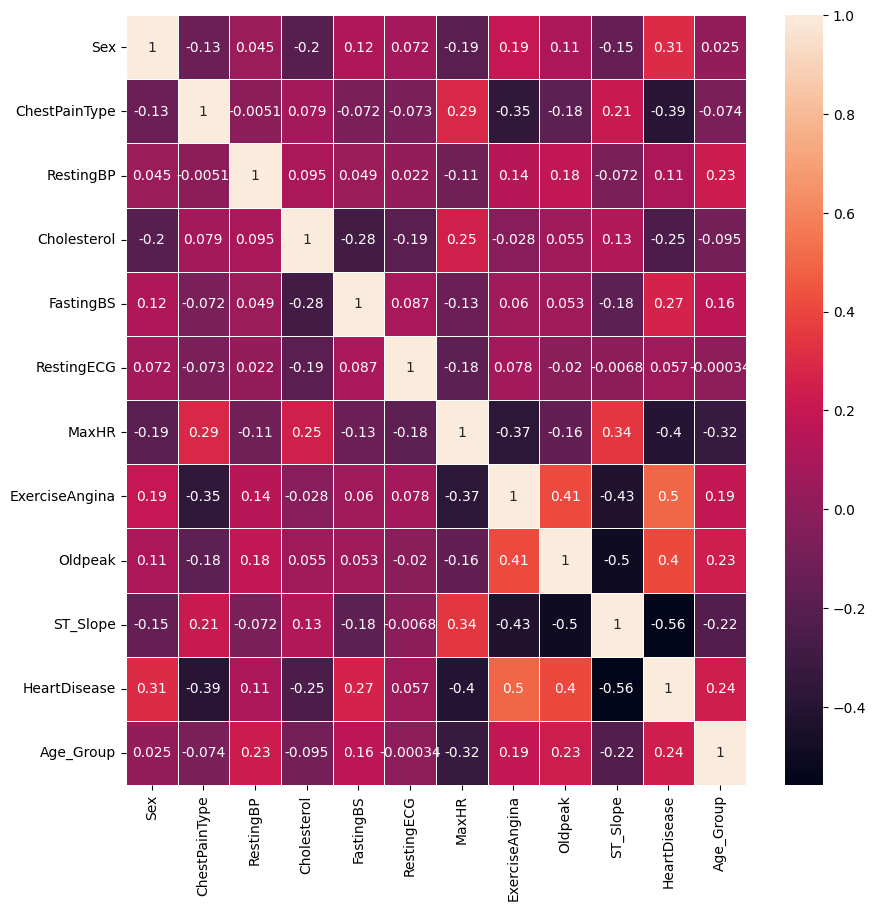

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)

## **Modeli**


In [ ]:
X = data.drop(columns = 'HeartDisease')
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Logistička regresija**

In [ ]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = lr.predict(X_test)

accuracy_score_LR = round(accuracy_score(y_test, y_pred), 4)
f1_score_LR = round(f1_score(y_test, y_pred), 4)

print(f'Accuracy score: {accuracy_score_LR}')
print(f'F1 Score: {f1_score_LR}')

Accuracy score: 0.8623
F1 Score: 0.8841


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       107
           1       0.91      0.86      0.88       169

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.86       276
weighted avg       0.87      0.86      0.86       276



#### LIME

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode='classification',
                                                   feature_names=X_train.columns.values.tolist(),
                                                   class_names=['NonHeartDisease', 'HeartDisease'],
                                                   verbose=True)

In [ ]:
sample_idx = 10
sample = X_test.iloc[sample_idx].values
true_label = y_test[sample_idx]

explanation = explainer.explain_instance(sample,
                                         lr.predict_proba,
                                         num_features=len(X_train.columns))

print("True Label:", true_label)

print("Predicted Probabilities:", lr.predict_proba([sample]))

explanation.show_in_notebook()

Intercept 0.052609430648389854
Prediction_local [1.05143472]
Right: 0.8624545154348687
True Label: 0
Predicted Probabilities: [[0.13754548 0.86245452]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### SHAP

In [ ]:
explainer = shap.Explainer(lr, X_train, feature_names = data.columns)
shap_values = explainer(X_test)

**Summary plot:**

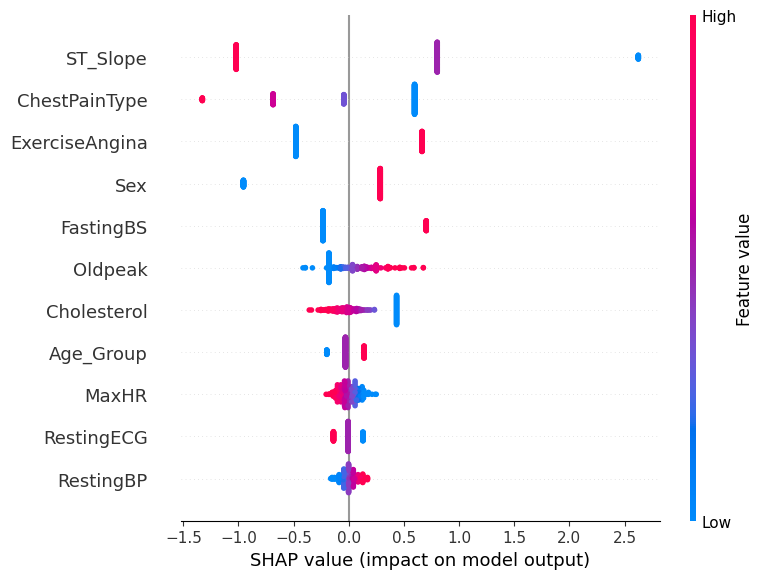

In [ ]:
shap.summary_plot(shap_values)

**Beeswarm:**

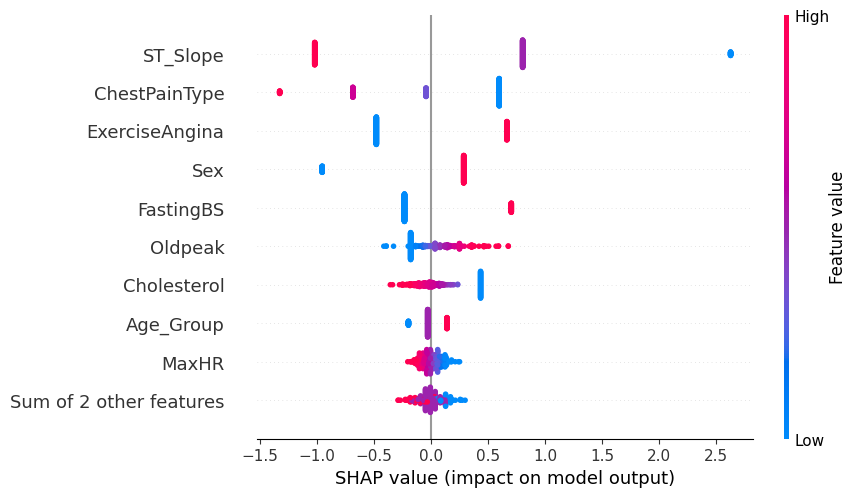

In [ ]:
shap.plots.beeswarm(shap_values)

**Force plot:**

In [ ]:
shap.initjs()

ind = 0
shap.plots.force(shap_values[ind])

In [ ]:
print("True" if y_test.iloc[ind] else "False", "\nHeart Disease Presence:")
print(X_test.iloc[ind])

False 
Heart Disease Presence:
Sex               0.000000
ChestPainType     1.000000
RestingBP         0.650000
Cholesterol       0.388060
FastingBS         0.000000
RestingECG        0.000000
MaxHR             0.809859
ExerciseAngina    0.000000
Oldpeak           0.363636
ST_Slope          1.000000
Age_Group         1.000000
Name: 669, dtype: float64


In [ ]:
shap.initjs()

shap.plots.force(shap_values[0:100])

In [ ]:
explainer = shap.Explainer(lr, X_train)

shap_values = explainer.shap_values(X_test)

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, X_test)

### **CNN**

In [ ]:
i_c = Input(shape=(X_train.shape[1],1))

x_c = Conv1D(16, 2, strides=1, activation='relu')(i_c)
x_c = MaxPooling1D(1)(x_c)

x_c = Conv1D(32, 2, strides=1, activation='relu')(i_c)
x_c = MaxPooling1D(1)(x_c)

x_c = Conv1D(16, 2, strides=1, activation='relu')(x_c)
x_c = MaxPooling1D(1)(x_c)

x_c = Flatten()(x_c)
# x_c = Dropout(0.3)(x_c)

y_c = Dense(1, activation='sigmoid')(x_c)

model_cnn = Model(inputs=i_c, outputs=y_c)

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            96        
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 16)             1040      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 9, 16)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 144)               0     

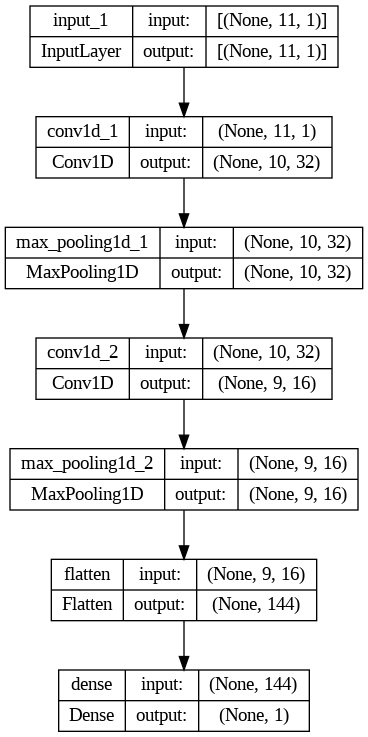

In [ ]:
model_cnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_cnn = model_cnn.fit(x=X_train, y=y_train,
                            validation_data = (X_test, y_test),
                            epochs = 50,
                            callbacks = [early_stopping])

Epoch 1/50
21/21 [==============================] - 2s 17ms/step - loss: 0.6450 - accuracy: 0.7051 - val_loss: 0.6101 - val_accuracy: 0.8333
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 0.5922 - accuracy: 0.8175 - val_loss: 0.5665 - val_accuracy: 0.8370
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5462 - accuracy: 0.8175 - val_loss: 0.5174 - val_accuracy: 0.8442
Epoch 4/50
21/21 [==============================] - 0s 5ms/step - loss: 0.4986 - accuracy: 0.8175 - val_loss: 0.4697 - val_accuracy: 0.8623
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 0.4581 - accuracy: 0.8284 - val_loss: 0.4283 - val_accuracy: 0.8514
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.4319 - accuracy: 0.8284 - val_loss: 0.4072 - val_accuracy: 0.8587
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.4132 - accuracy: 0.8346 - val_loss: 0.3988 - val_accuracy: 0.8623
Epoch 8/50
21/21 [=

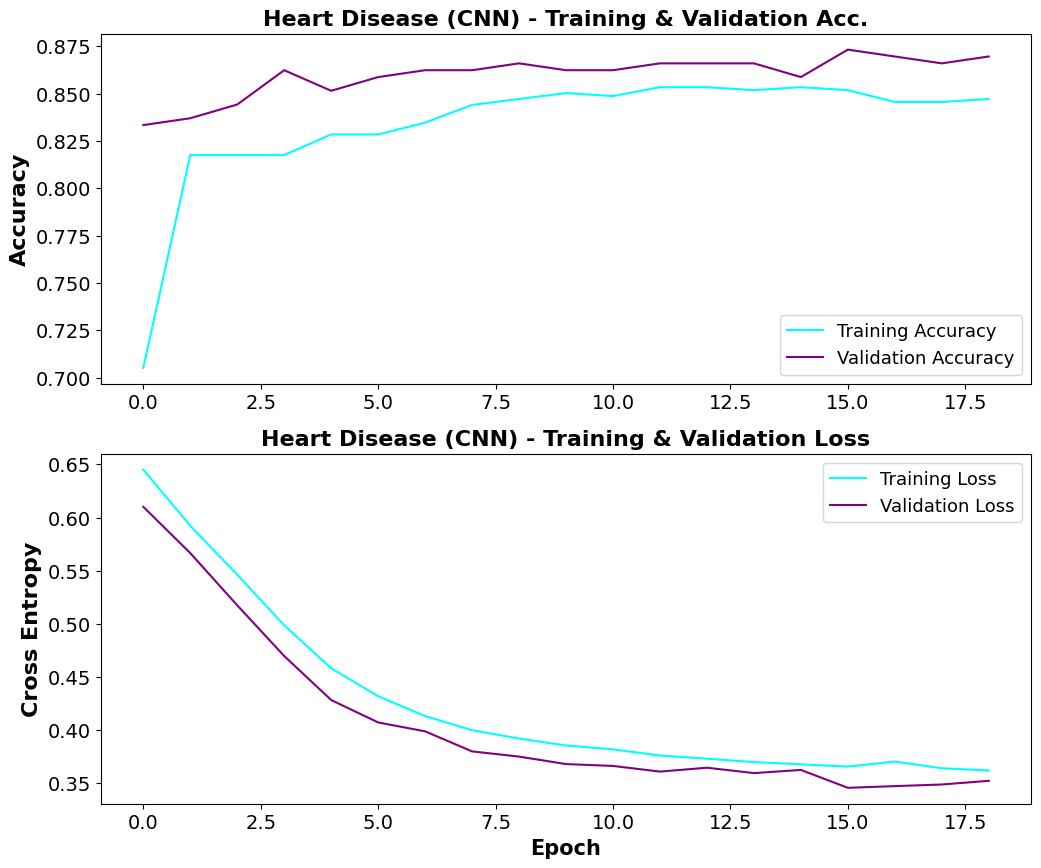

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='cyan')
plt.plot(val_acc, label='Validation Accuracy', color='purple')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Heart Disease (CNN) - Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='cyan')
plt.plot(val_loss, label='Validation Loss', color='purple')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Heart Disease (CNN) - Training & Validation Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [ ]:
Y_pred_c = model_cnn.predict(X_test)
y_pred_c = np.round(Y_pred_c).astype(int)

print(classification_report(y_test, y_pred_c))

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       107
           1       0.91      0.87      0.89       169

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276



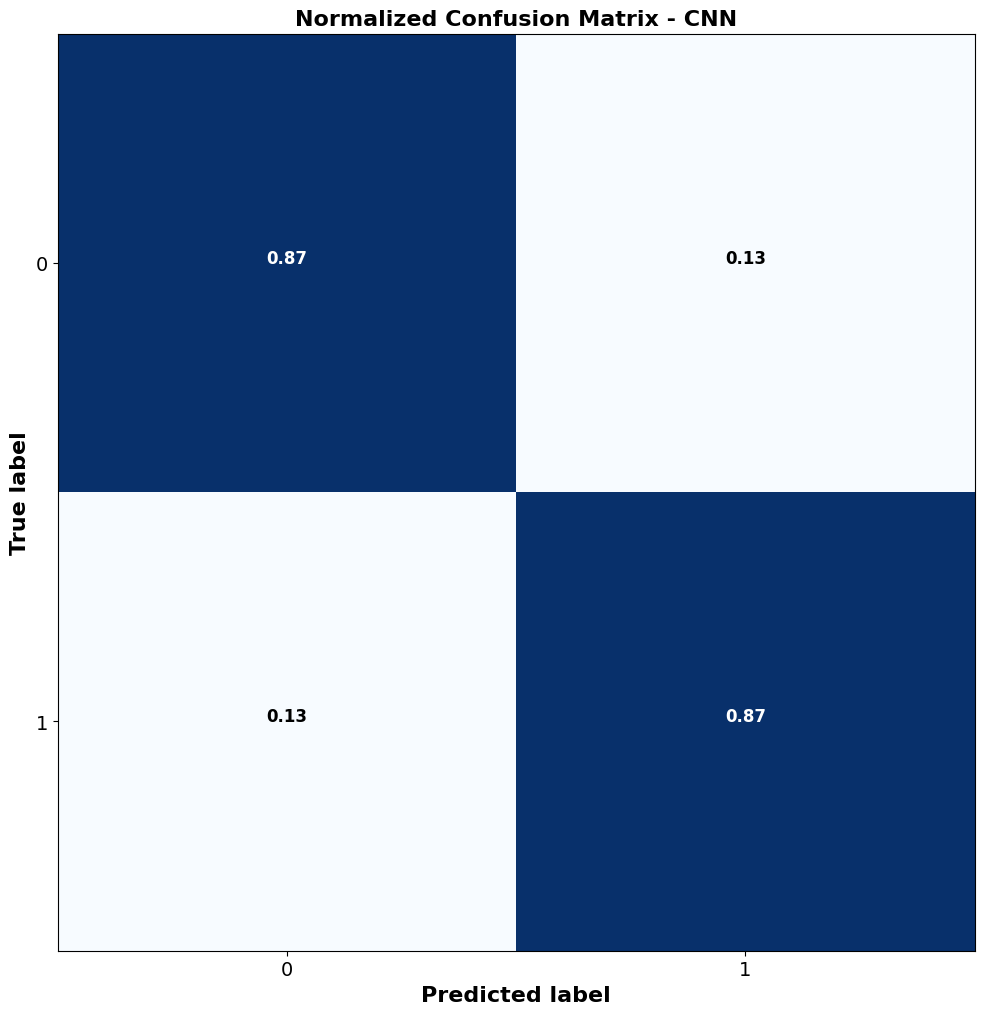

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = confusion_matrix(y_test, y_pred_c)
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], normalize=True, title='Normalized Confusion Matrix - CNN')
plt.show()

#### LIME

In [ ]:
class_names = ['Heart Disease', 'Non-Heart Disease']

feature_names = list(X_train.columns)

explainer = LimeTabularExplainer(X_train.values,
                                 feature_names = feature_names,
                                 class_names = class_names,
                                 mode = 'classification')

In [ ]:
sample_idx = 10
sample = X_test.iloc[sample_idx].values
true_label = y_test[sample_idx]

true_label_text = 'Heart Disease' if true_label == 1 else 'Non-Heart Disease'

def cnn_predict_proba(X):
    return model_cnn.predict(X)

def cnn_predict(X):
    proba = cnn_predict_proba(X)
    return np.column_stack([1 - proba, proba])

print("True Label:", true_label_text)

print("Predicted Probabilities:", cnn_predict_proba(sample.reshape(1, -1)))

True Label: Non-Heart Disease
1/1 [==============================] - 0s 139ms/step
Predicted Probabilities: [[0.93]]


In [ ]:
explanation = explainer.explain_instance(sample,
                                         cnn_predict,
                                         num_features=len(X_train.columns))


explanation.show_in_notebook()

157/157 [==============================] - 0s 2ms/step


#### SHAP

In [ ]:
def model_predict(data):
    return model_cnn.predict(data)

explainer = shap.Explainer(model_predict, X_train)
shap_values = explainer(X_test)

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   1%|          | 2/276 [00:00<?, ?it/s]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   1%|▏         | 4/276 [00:17<13:23,  2.96s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:   2%|▏         | 5/276 [00:25<22:57,  5.08s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   2%|▏         | 6/276 [00:31<24:22,  5.42s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   3%|▎         | 7/276 [00:38<26:48,  5.98s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 8/276 [00:44<26:50,  6.01s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 9/276 [00:50<26:41,  6.00s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 10/276 [00:57<27:51,  6.28s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 11/276 [01:02<27:01,  6.12s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   4%|▍         | 12/276 [01:10<29:30,  6.71s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   5%|▍         | 13/276 [01:16<27:52,  6.36s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:   5%|▌         | 14/276 [01:24<29:26,  6.74s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   5%|▌         | 15/276 [01:29<27:26,  6.31s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   6%|▌         | 16/276 [01:35<27:01,  6.24s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 17/276 [01:42<27:32,  6.38s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 18/276 [01:49<28:05,  6.53s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 19/276 [01:57<29:44,  6.94s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:   7%|▋         | 20/276 [02:04<30:25,  7.13s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 21/276 [02:12<30:54,  7.27s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 22/276 [02:17<28:32,  6.74s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 23/276 [02:24<28:56,  6.86s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   9%|▊         | 24/276 [02:30<26:42,  6.36s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:   9%|▉         | 25/276 [02:36<26:12,  6.27s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   9%|▉         | 26/276 [02:43<27:21,  6.56s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  10%|▉         | 27/276 [02:48<26:06,  6.29s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  10%|█         | 28/276 [02:56<27:13,  6.59s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  11%|█         | 29/276 [03:04<28:45,  6.99s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  11%|█         | 30/276 [03:10<27:27,  6.70s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 31/276 [03:15<25:31,  6.25s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 32/276 [03:22<26:22,  6.49s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 33/276 [03:28<25:35,  6.32s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 34/276 [03:35<26:27,  6.56s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 35/276 [03:40<24:41,  6.15s/it]

36/36 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  13%|█▎        | 36/276 [03:49<27:22,  6.84s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 37/276 [03:55<26:19,  6.61s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  14%|█▍        | 38/276 [04:00<24:29,  6.17s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 39/276 [04:06<24:45,  6.27s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 40/276 [04:12<24:02,  6.11s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  15%|█▍        | 41/276 [04:19<24:51,  6.35s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  15%|█▌        | 42/276 [04:24<23:44,  6.09s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  16%|█▌        | 43/276 [04:31<23:59,  6.18s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 44/276 [04:36<22:56,  5.93s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  16%|█▋        | 45/276 [04:42<22:15,  5.78s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 46/276 [04:48<23:10,  6.04s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 47/276 [04:53<21:59,  5.76s/it]

32/32 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  17%|█▋        | 48/276 [05:00<22:43,  5.98s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 49/276 [05:06<22:51,  6.04s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 50/276 [05:11<21:39,  5.75s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 51/276 [05:18<22:41,  6.05s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 52/276 [05:23<21:22,  5.72s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 53/276 [05:31<23:29,  6.32s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  20%|█▉        | 54/276 [05:36<22:09,  5.99s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  20%|█▉        | 55/276 [05:42<21:54,  5.95s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 56/276 [05:48<22:03,  6.02s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 57/276 [05:53<20:40,  5.67s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 58/276 [06:00<22:05,  6.08s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  21%|██▏       | 59/276 [06:05<21:05,  5.83s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  22%|██▏       | 60/276 [06:11<20:56,  5.82s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  22%|██▏       | 61/276 [06:17<20:52,  5.82s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 62/276 [06:22<20:05,  5.63s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 63/276 [06:29<21:18,  6.00s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  23%|██▎       | 64/276 [06:34<20:46,  5.88s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  24%|██▎       | 65/276 [06:43<23:12,  6.60s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 66/276 [06:48<22:03,  6.30s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  24%|██▍       | 67/276 [06:55<22:11,  6.37s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  25%|██▍       | 68/276 [07:01<21:49,  6.29s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 69/276 [07:06<20:07,  5.83s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 70/276 [07:13<21:17,  6.20s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 71/276 [07:18<19:57,  5.84s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 72/276 [07:25<21:53,  6.44s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  26%|██▋       | 73/276 [07:31<20:34,  6.08s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  27%|██▋       | 74/276 [07:38<21:42,  6.45s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 75/276 [07:44<21:20,  6.37s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 76/276 [07:49<19:50,  5.95s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  28%|██▊       | 77/276 [07:57<21:09,  6.38s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  28%|██▊       | 78/276 [08:04<21:52,  6.63s/it]

37/37 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  29%|██▊       | 79/276 [08:12<23:18,  7.10s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 80/276 [08:17<21:30,  6.59s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  29%|██▉       | 81/276 [08:24<21:44,  6.69s/it]

29/29 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  30%|██▉       | 82/276 [08:30<20:14,  6.26s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  30%|███       | 83/276 [08:35<19:14,  5.98s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 84/276 [08:42<19:54,  6.22s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 85/276 [08:47<18:45,  5.89s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 86/276 [08:54<19:35,  6.18s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 87/276 [08:59<18:40,  5.93s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 88/276 [09:04<17:55,  5.72s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 89/276 [09:11<19:04,  6.12s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 90/276 [09:17<18:21,  5.92s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  33%|███▎      | 91/276 [09:24<19:23,  6.29s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 92/276 [09:31<19:47,  6.46s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  34%|███▎      | 93/276 [09:38<20:06,  6.59s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 94/276 [09:43<19:06,  6.30s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  34%|███▍      | 95/276 [09:49<18:54,  6.27s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  35%|███▍      | 96/276 [09:56<19:08,  6.38s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 97/276 [10:01<17:43,  5.94s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 98/276 [10:08<18:27,  6.22s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 99/276 [10:13<17:17,  5.86s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  36%|███▌      | 100/276 [10:20<17:57,  6.12s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 101/276 [10:26<18:23,  6.31s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 102/276 [10:33<18:58,  6.54s/it]

30/30 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 103/276 [10:39<17:54,  6.21s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 104/276 [10:44<16:50,  5.88s/it]

30/30 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 105/276 [10:51<17:32,  6.16s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 106/276 [10:56<16:23,  5.78s/it]

32/32 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  39%|███▉      | 107/276 [11:02<16:36,  5.90s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  39%|███▉      | 108/276 [11:09<17:17,  6.17s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  39%|███▉      | 109/276 [11:16<18:19,  6.58s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 110/276 [11:22<17:25,  6.30s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  40%|████      | 111/276 [11:29<17:41,  6.43s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 112/276 [11:35<17:33,  6.42s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 113/276 [11:40<16:34,  6.10s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  41%|████▏     | 114/276 [11:48<17:44,  6.57s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  42%|████▏     | 115/276 [11:54<17:34,  6.55s/it]

30/30 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 116/276 [12:01<17:42,  6.64s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 117/276 [12:08<17:49,  6.73s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  43%|████▎     | 118/276 [12:16<18:26,  7.00s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  43%|████▎     | 119/276 [12:22<17:24,  6.65s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  43%|████▎     | 120/276 [12:29<17:45,  6.83s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  44%|████▍     | 121/276 [12:35<17:02,  6.60s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  44%|████▍     | 122/276 [12:42<16:51,  6.57s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  45%|████▍     | 123/276 [12:49<17:22,  6.82s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  45%|████▍     | 124/276 [12:57<18:11,  7.18s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  45%|████▌     | 125/276 [13:04<17:58,  7.14s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  46%|████▌     | 126/276 [13:11<17:27,  6.99s/it]

30/30 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  46%|████▌     | 127/276 [13:18<17:24,  7.01s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  46%|████▋     | 128/276 [13:24<16:50,  6.83s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 129/276 [13:32<17:45,  7.25s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  47%|████▋     | 130/276 [13:39<17:22,  7.14s/it]

37/37 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 131/276 [13:48<18:10,  7.52s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 132/276 [13:53<16:38,  6.93s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 133/276 [14:00<16:44,  7.03s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  49%|████▊     | 134/276 [14:05<15:07,  6.39s/it]

30/30 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  49%|████▉     | 135/276 [14:12<15:26,  6.57s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  49%|████▉     | 136/276 [14:18<14:50,  6.36s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  50%|████▉     | 137/276 [14:24<14:32,  6.28s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 138/276 [14:30<14:20,  6.24s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  50%|█████     | 139/276 [14:38<15:02,  6.59s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  51%|█████     | 140/276 [14:45<15:18,  6.76s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  51%|█████     | 141/276 [14:51<14:37,  6.50s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  51%|█████▏    | 142/276 [14:58<14:45,  6.61s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 143/276 [15:04<14:20,  6.47s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 144/276 [15:11<14:26,  6.56s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 145/276 [15:17<14:25,  6.61s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  53%|█████▎    | 146/276 [15:25<15:09,  7.00s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 147/276 [15:31<14:16,  6.64s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  54%|█████▎    | 148/276 [15:36<13:16,  6.22s/it]

33/33 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  54%|█████▍    | 149/276 [15:45<14:23,  6.80s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  54%|█████▍    | 150/276 [15:50<13:25,  6.39s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  55%|█████▍    | 151/276 [15:57<13:52,  6.66s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  55%|█████▌    | 152/276 [16:02<12:49,  6.21s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  55%|█████▌    | 153/276 [16:09<13:15,  6.47s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 154/276 [16:16<13:05,  6.44s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 155/276 [16:23<13:27,  6.67s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  57%|█████▋    | 156/276 [16:28<12:28,  6.24s/it]

30/30 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  57%|█████▋    | 157/276 [16:34<12:00,  6.05s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  57%|█████▋    | 158/276 [16:40<12:02,  6.12s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 159/276 [16:45<11:07,  5.70s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 160/276 [16:52<11:41,  6.04s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  58%|█████▊    | 161/276 [16:58<11:43,  6.12s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  59%|█████▊    | 162/276 [17:04<11:49,  6.22s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  59%|█████▉    | 163/276 [17:10<11:15,  5.98s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  59%|█████▉    | 164/276 [17:15<10:42,  5.74s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  60%|█████▉    | 165/276 [17:23<11:56,  6.46s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  60%|██████    | 166/276 [17:30<11:45,  6.41s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 167/276 [17:36<11:52,  6.53s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 168/276 [17:43<11:53,  6.61s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 169/276 [17:51<12:16,  6.89s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 170/276 [17:56<11:31,  6.52s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 171/276 [18:04<12:14,  6.99s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  62%|██████▏   | 172/276 [18:11<12:06,  6.99s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 173/276 [18:18<12:00,  6.99s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 174/276 [18:25<11:45,  6.91s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 175/276 [18:33<12:15,  7.28s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  64%|██████▍   | 176/276 [18:39<11:19,  6.79s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  64%|██████▍   | 177/276 [18:45<10:53,  6.60s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 178/276 [18:52<10:51,  6.65s/it]

34/34 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  65%|██████▍   | 179/276 [18:59<11:08,  6.89s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  65%|██████▌   | 180/276 [19:06<11:08,  6.96s/it]

32/32 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  66%|██████▌   | 181/276 [19:13<10:47,  6.82s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 182/276 [19:20<10:52,  6.94s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  66%|██████▋   | 183/276 [19:30<11:58,  7.73s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 184/276 [19:36<11:08,  7.27s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  67%|██████▋   | 185/276 [19:43<11:00,  7.26s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  67%|██████▋   | 186/276 [19:50<10:47,  7.20s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  68%|██████▊   | 187/276 [19:57<10:37,  7.17s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 188/276 [20:05<10:42,  7.30s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  68%|██████▊   | 189/276 [20:12<10:42,  7.39s/it]

31/31 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  69%|██████▉   | 190/276 [20:21<11:06,  7.75s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  69%|██████▉   | 191/276 [20:30<11:24,  8.05s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  70%|██████▉   | 192/276 [20:36<10:28,  7.49s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  70%|██████▉   | 193/276 [20:44<10:25,  7.53s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  70%|███████   | 194/276 [20:50<09:48,  7.18s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  71%|███████   | 195/276 [20:58<10:09,  7.52s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  71%|███████   | 196/276 [21:05<09:51,  7.40s/it]

32/32 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  71%|███████▏  | 197/276 [21:14<10:01,  7.62s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 198/276 [21:19<09:13,  7.10s/it]

32/32 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  72%|███████▏  | 199/276 [21:27<09:10,  7.15s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 200/276 [21:34<09:15,  7.31s/it]

30/30 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  73%|███████▎  | 201/276 [21:41<08:46,  7.02s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  73%|███████▎  | 202/276 [21:48<08:40,  7.04s/it]

32/32 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  74%|███████▎  | 203/276 [21:55<08:35,  7.07s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  74%|███████▍  | 204/276 [22:02<08:19,  6.94s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  74%|███████▍  | 205/276 [22:09<08:17,  7.01s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  75%|███████▍  | 206/276 [22:16<08:10,  7.01s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 207/276 [22:22<07:51,  6.83s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  75%|███████▌  | 208/276 [22:30<08:02,  7.10s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 209/276 [22:37<07:58,  7.14s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 210/276 [22:44<07:52,  7.16s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  76%|███████▋  | 211/276 [22:52<07:55,  7.32s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 212/276 [23:00<08:04,  7.56s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  77%|███████▋  | 213/276 [23:07<07:48,  7.44s/it]

35/35 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  78%|███████▊  | 214/276 [23:15<07:45,  7.51s/it]

31/31 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  78%|███████▊  | 215/276 [23:22<07:22,  7.26s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 216/276 [23:30<07:29,  7.50s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  79%|███████▊  | 217/276 [23:35<06:52,  6.98s/it]

31/31 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  79%|███████▉  | 218/276 [23:43<06:59,  7.23s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  79%|███████▉  | 219/276 [23:49<06:19,  6.65s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  80%|███████▉  | 220/276 [23:56<06:29,  6.96s/it]

37/37 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 221/276 [24:04<06:29,  7.09s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  80%|████████  | 222/276 [24:11<06:30,  7.24s/it]

30/30 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 223/276 [24:19<06:27,  7.32s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  81%|████████  | 224/276 [24:27<06:36,  7.62s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 225/276 [24:34<06:17,  7.41s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 226/276 [24:42<06:17,  7.55s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 227/276 [24:48<05:44,  7.03s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 228/276 [24:55<05:45,  7.20s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  83%|████████▎ | 229/276 [25:04<05:54,  7.54s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  83%|████████▎ | 230/276 [25:12<05:55,  7.73s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  84%|████████▎ | 231/276 [25:19<05:34,  7.44s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 232/276 [25:26<05:30,  7.51s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  84%|████████▍ | 233/276 [25:33<05:09,  7.19s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  85%|████████▍ | 234/276 [25:41<05:10,  7.39s/it]

30/30 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  85%|████████▌ | 235/276 [25:46<04:38,  6.80s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 236/276 [25:54<04:46,  7.17s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 237/276 [26:00<04:29,  6.90s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  86%|████████▌ | 238/276 [26:08<04:28,  7.07s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  87%|████████▋ | 239/276 [26:15<04:27,  7.24s/it]

30/30 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  87%|████████▋ | 240/276 [26:22<04:18,  7.19s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  87%|████████▋ | 241/276 [26:30<04:11,  7.20s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 242/276 [26:38<04:13,  7.46s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 243/276 [26:44<03:52,  7.04s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  88%|████████▊ | 244/276 [26:52<03:54,  7.31s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  89%|████████▉ | 245/276 [26:59<03:49,  7.40s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  89%|████████▉ | 246/276 [27:07<03:45,  7.51s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 247/276 [27:15<03:38,  7.53s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  90%|████████▉ | 248/276 [27:22<03:29,  7.48s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  90%|█████████ | 249/276 [27:28<03:05,  6.89s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  91%|█████████ | 250/276 [27:35<03:01,  6.99s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  91%|█████████ | 251/276 [27:42<02:59,  7.19s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  91%|█████████▏| 252/276 [27:49<02:49,  7.08s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 253/276 [27:57<02:43,  7.13s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  92%|█████████▏| 254/276 [28:03<02:34,  7.03s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 255/276 [28:11<02:31,  7.21s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  93%|█████████▎| 256/276 [28:18<02:25,  7.26s/it]

34/34 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 257/276 [28:26<02:17,  7.26s/it]

34/34 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  93%|█████████▎| 258/276 [28:33<02:10,  7.23s/it]

35/35 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 259/276 [28:41<02:06,  7.46s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  94%|█████████▍| 260/276 [28:49<02:00,  7.56s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▍| 261/276 [28:55<01:50,  7.37s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▍| 262/276 [29:03<01:43,  7.38s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▌| 263/276 [29:10<01:33,  7.20s/it]

33/33 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  96%|█████████▌| 264/276 [29:16<01:23,  6.95s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▌| 265/276 [29:23<01:18,  7.10s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▋| 266/276 [29:29<01:07,  6.77s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 267/276 [29:38<01:04,  7.17s/it]

31/31 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 268/276 [29:44<00:56,  7.03s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 269/276 [29:52<00:50,  7.25s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 270/276 [29:59<00:42,  7.17s/it]

33/33 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 271/276 [30:06<00:36,  7.23s/it]

36/36 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▊| 272/276 [30:14<00:29,  7.37s/it]

34/34 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  99%|█████████▉| 273/276 [30:22<00:22,  7.51s/it]

35/35 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  99%|█████████▉| 274/276 [30:30<00:15,  7.63s/it]

32/32 [==============================] - 0s 2ms/step


PermutationExplainer explainer: 100%|█████████▉| 275/276 [30:38<00:07,  7.74s/it]

32/32 [==============================] - 0s 3ms/step


PermutationExplainer explainer: 100%|██████████| 276/276 [30:45<00:00,  7.56s/it]

33/33 [==============================] - 0s 2ms/step


PermutationExplainer explainer: 277it [30:52,  6.74s/it]


In [ ]:
np.shape(shap_values.values)

(276, 11)

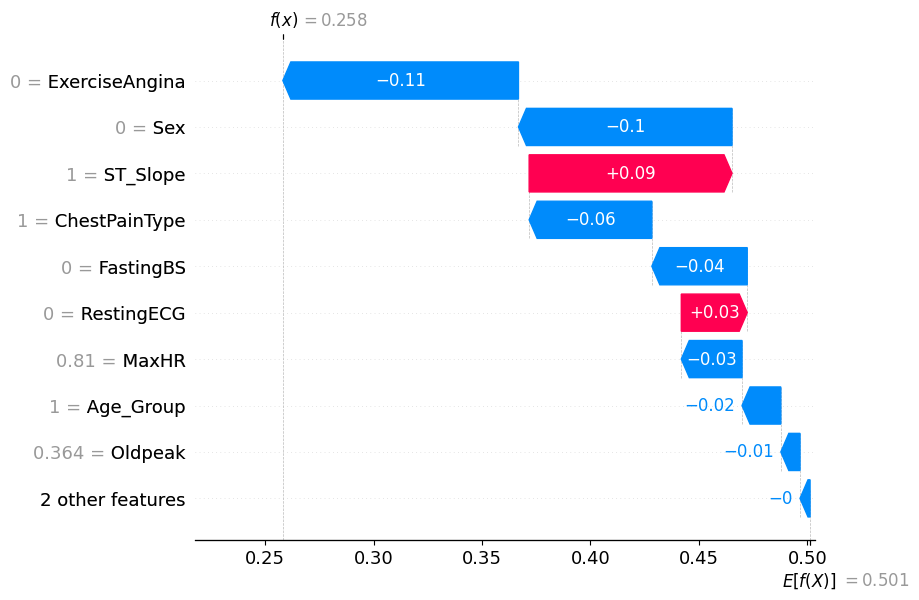

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()

shap.plots.force(shap_values[0])

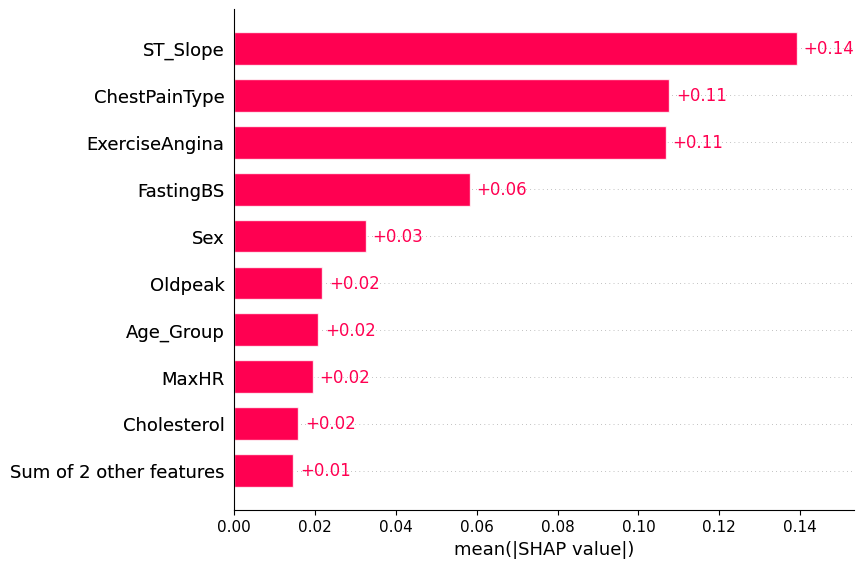

In [ ]:
shap.plots.bar(shap_values)

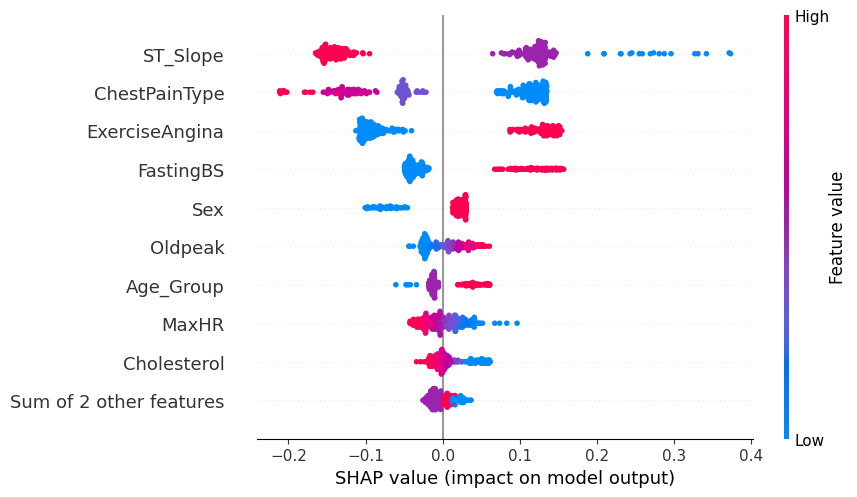

In [ ]:
shap.plots.beeswarm(shap_values)